In [ ]:
#import packages
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.models as models
import glob
import shutil
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
#Splitting the data

# Defining the path to dataset
dataset_path = '/content/drive/MyDrive/PlantVillage'

train_ratio = 0.75
valid_ratio = 0.10
test_ratio = 0.15

# The path to the output directory
output_path = '/content/drive/MyDrive/PVdatasetsplit'

# Create the output directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Defining the names of the subdirectories for each set
train_dir = 'train'
valid_dir = 'valid'
test_dir = 'test'

# Creating the subdirectories for each set
os.makedirs(os.path.join(output_path, train_dir))
os.makedirs(os.path.join(output_path, valid_dir))
os.makedirs(os.path.join(output_path, test_dir))

# Loop over each class in the dataset
classes = os.listdir(dataset_path)
for cls in classes:
    # Create the subdirectories for each class in each set
    os.makedirs(os.path.join(output_path, train_dir, cls))
    os.makedirs(os.path.join(output_path, valid_dir, cls))
    os.makedirs(os.path.join(output_path, test_dir, cls))

    # Get the list of images for this class
    images = os.listdir(os.path.join(dataset_path, cls))
    num_images = len(images)

    # Shuffle the images
    random.shuffle(images)

    # Split the images into sets
    num_train = int(train_ratio * num_images)
    num_valid = int(valid_ratio * num_images)
    num_test = int(test_ratio * num_images)

    train_images = images[:num_train]
    valid_images = images[num_train:num_train+num_valid]
    test_images = images[num_train+num_valid:]

    # Copy the images to the corresponding subdirectories for each set
    for img in train_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, train_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in valid_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, valid_dir, cls, img)
        shutil.copyfile(src_path, dst_path)

    for img in test_images:
        src_path = os.path.join(dataset_path, cls, img)
        dst_path = os.path.join(output_path, test_dir, cls, img)
        shutil.copyfile(src_path, dst_path)


In [ ]:
# Defining the transformation pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by up to 10 degrees
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
    transforms.Normalize(  # Normalize the images
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Load the dataset
train_dataset = ImageFolder('/content/drive/MyDrive/PVdatasetsplit/train', transform=transform)
test_dataset = ImageFolder('/content/drive/MyDrive/PVdatasetsplit/test', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/PVdatasetsplit/valid', transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


# Define the model architecture
model = models.mobilenet_v2(weights=None)
model.classifier = nn.Sequential(
    nn.Linear(
        , 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 15)
)




In [ ]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs to train for
num_epochs = 5

# Define the path to save/load checkpoints
checkpoint_path = '/content/drive/MyDrive/checkpoint_PlantVillage_MN/checkpoint_{epoch}.pt'

# Check if a checkpoint exists and load it if so
try: 
    latest_checkpoint = max(glob.glob('/content/drive/MyDrive/checkpoint_PlantVillage_MN/*.pt'), key=os.path.getctime)
    checkpoint_dict = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
    start_epoch = checkpoint_dict['epoch']
    print(f"Loaded checkpoint from epoch {start_epoch}.")
except ValueError:
    print("No checkpoint found. Starting from epoch 1.")
    start_epoch = 0

# Create lists to store train and validation loss and accuracy
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Train the model
for epoch in range(start_epoch+1, num_epochs+1):
    # Set the model to training mode
    model.train()
    train_loss = 0
    total_train_images = 0
    total_train_correct = 0

    # Loop over the training dataset in batches
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training loss and accuracy
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_images += labels.size(0)

    # Calculate training accuracy
    train_acc = total_train_correct / total_train_images

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        total_val_images = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            total_val_images += labels.size(0)
        val_loss = total_val_loss / total_val_images
        val_acc = total_val_correct / total_val_images
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
              .format(epoch, num_epochs, train_loss/len(train_loader.dataset), train_acc*100, val_loss/len(val_loader.dataset), val_acc*100))
    
    # Append training and validation metrics to the corresponding lists
    train_loss_list.append(train_loss/len(train_loader.dataset))
    train_acc_list.append(train_acc*100)
    val_loss_list.append(val_loss/len(val_loader.dataset))
    val_acc_list.append(val_acc*100)

    # Save a checkpoint
    checkpoint_file = checkpoint_path.format(epoch=epoch)
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint_dict, checkpoint_file)
    print(f"Saved checkpoint for epoch {epoch}.")

No checkpoint found. Starting from epoch 1.


Epoch 1/5: 100%|██████████| 483/483 [57:14<00:00,  7.11s/it]


Epoch [1/5], Training Loss: 1.7396, Training Accuracy: 42.32%, Validation Loss: 0.0008, Validation Accuracy: 45.93%
Saved checkpoint for epoch 1.


Epoch 2/5: 100%|██████████| 483/483 [25:11<00:00,  3.13s/it]


Epoch [2/5], Training Loss: 1.4422, Training Accuracy: 51.35%, Validation Loss: 0.0006, Validation Accuracy: 60.79%
Saved checkpoint for epoch 2.


Epoch 3/5: 100%|██████████| 483/483 [24:59<00:00,  3.11s/it]


Epoch [3/5], Training Loss: 1.2287, Training Accuracy: 59.10%, Validation Loss: 0.0006, Validation Accuracy: 59.96%
Saved checkpoint for epoch 3.


Epoch 4/5: 100%|██████████| 483/483 [25:07<00:00,  3.12s/it]


Epoch [4/5], Training Loss: 1.0968, Training Accuracy: 63.27%, Validation Loss: 0.0004, Validation Accuracy: 68.05%
Saved checkpoint for epoch 4.


Epoch 5/5: 100%|██████████| 483/483 [25:00<00:00,  3.11s/it]


Epoch [5/5], Training Loss: 0.9814, Training Accuracy: 67.12%, Validation Loss: 0.0004, Validation Accuracy: 70.73%
Saved checkpoint for epoch 5.


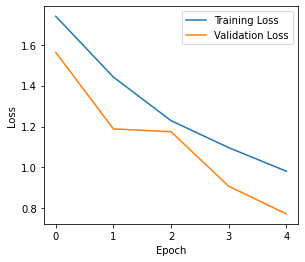

In [ ]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

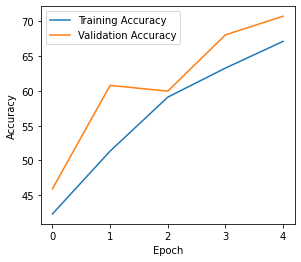

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 2)
plt.plot(train_acc_list, label='Training Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.5924, Recall: 0.5755, F-score: 0.5454
Confusion matrix:
 [[ 15  76   8   0   0   0   1   7   3  41   0   0   1   0   0]
 [  0 209   1   0   0   0   1   0   0  12   0   0   0   0   0]
 [  0   0 143   8   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   7  87   0   1   1  40   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   0   0  20   0   5   0   0   0]
 [  0   6   0   1   0 298   0   0   1   0   1   0  13   0   0]
 [  0   6   8  12   0  21  11  73   0   7   0   8   4   0   0]
 [  0   0  15  45   0  12  13 196   0   0   1   0   6   0   0]
 [  1   1   1   1   0   0   0   1  33  83   3   6  13   0   0]
 [  0   5   7   6   0   0   1   4   7 229   0   4   3   0   0]
 [  0   0   0   0   0   1   0   1   4   3 130 111   1   0   1]
 [  0   0   0   3   0   1   0   0   1   8  12 180   0   0   6]
 [  7  23   0   0   0   8   0   1   0   0   9   0 434   0   0]
 [  0   0   0   0   0   0   0   0   1  56   0   0   0   0   0]
 [  0   0   0   0   0   1   0   1   0   0   0   

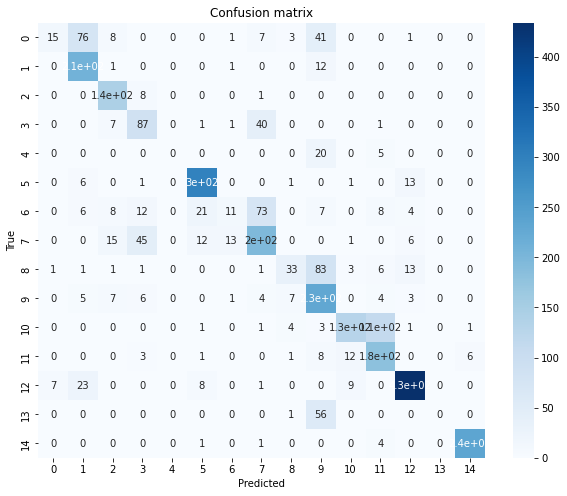

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
pred_labels = []

# Loop over the validation dataset in batches
for images, labels in test_loader:
    # Predict the labels
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append the true and predicted labels to the corresponding lists
    true_labels.extend(labels.tolist())
    pred_labels.extend(predicted.tolist())

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Compute precision, recall, and F-score
precision = precision_score(true_labels, pred_labels, average='macro')
recall = recall_score(true_labels, pred_labels, average='macro')
f_score = f1_score(true_labels, pred_labels, average='macro')

print('Precision: {:.4f}, Recall: {:.4f}, F-score: {:.4f}'.format(precision, recall, f_score))
print('Confusion matrix:\n', conf_matrix)

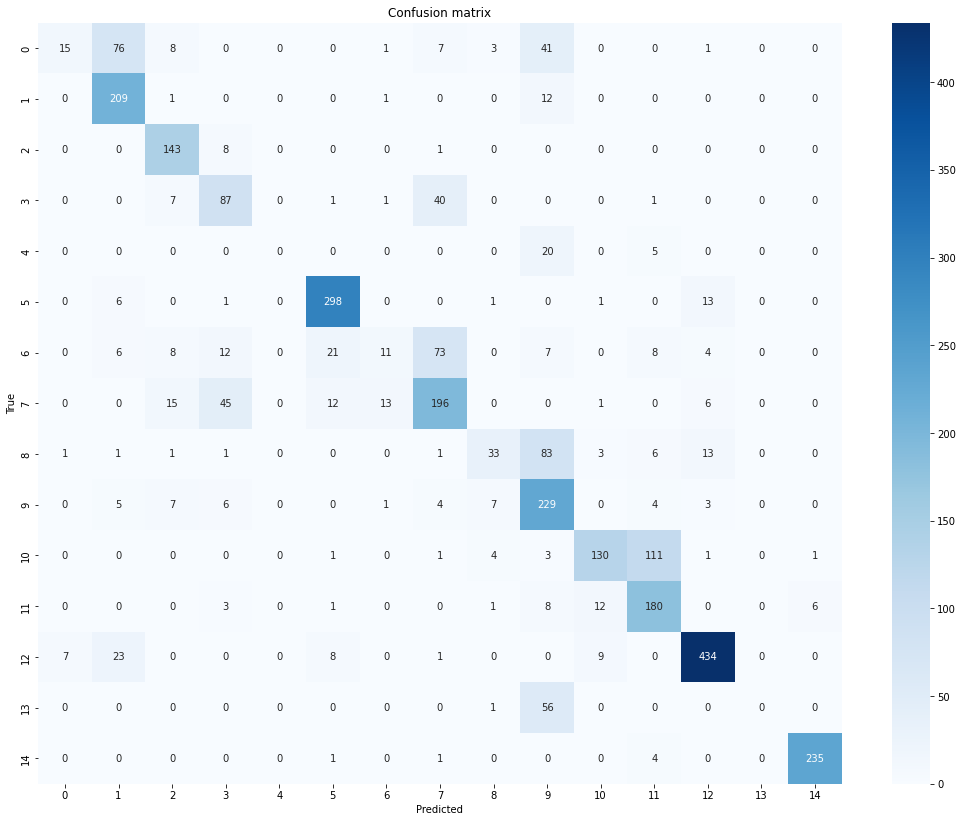

In [ ]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 14))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs to train for
num_epochs = 10

# Define the path to save/load checkpoints
checkpoint_path = '/content/drive/MyDrive/checkpoint_PlantVillage_MN/checkpoint_{epoch}.pt'

# Check if a checkpoint exists and load it if so
try: 
    latest_checkpoint = max(glob.glob('/content/drive/MyDrive/checkpoint_PlantVillage_MN/*.pt'), key=os.path.getctime)
    checkpoint_dict = torch.load(latest_checkpoint)
    model.load_state_dict(checkpoint_dict['model_state_dict'])
    optimizer.load_state_dict(checkpoint_dict['optimizer_state_dict'])
    start_epoch = checkpoint_dict['epoch']
    print(f"Loaded checkpoint from epoch {start_epoch}.")
except ValueError:
    print("No checkpoint found. Starting from epoch 1.")
    start_epoch = 0

# Create lists to store train and validation loss and accuracy
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# Train the model
for epoch in range(start_epoch+1, num_epochs+1):
    # Set the model to training mode
    model.train()
    train_loss = 0
    total_train_images = 0
    total_train_correct = 0

    # Loop over the training dataset in batches
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch}/{num_epochs}'):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate training loss and accuracy
        train_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == labels).sum().item()
        total_train_images += labels.size(0)

    # Calculate training accuracy
    train_acc = total_train_correct / total_train_images

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        total_val_loss = 0
        total_val_correct = 0
        total_val_images = 0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == labels).sum().item()
            total_val_images += labels.size(0)
        val_loss = total_val_loss / total_val_images
        val_acc = total_val_correct / total_val_images
        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'
              .format(epoch, num_epochs, train_loss/len(train_loader.dataset), train_acc*100, val_loss/len(val_loader.dataset), val_acc*100))
    
    # Append training and validation metrics to the corresponding lists
    train_loss_list.append(train_loss/len(train_loader.dataset))
    train_acc_list.append(train_acc*100)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc*100)

    # Save a checkpoint
    checkpoint_file = checkpoint_path.format(epoch=epoch)
    checkpoint_dict = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint_dict, checkpoint_file)
    print(f"Saved checkpoint for epoch {epoch}.")

Loaded checkpoint from epoch 5.


Epoch 6/10: 100%|██████████| 483/483 [24:37<00:00,  3.06s/it]


Epoch [6/10], Training Loss: 0.8548, Training Accuracy: 71.73%, Validation Loss: 0.0004, Validation Accuracy: 73.06%
Saved checkpoint for epoch 6.


Epoch 7/10: 100%|██████████| 483/483 [24:28<00:00,  3.04s/it]


Epoch [7/10], Training Loss: 0.7713, Training Accuracy: 74.95%, Validation Loss: 0.0003, Validation Accuracy: 79.74%
Saved checkpoint for epoch 7.


Epoch 8/10: 100%|██████████| 483/483 [24:10<00:00,  3.00s/it]


Epoch [8/10], Training Loss: 0.6811, Training Accuracy: 78.30%, Validation Loss: 0.0003, Validation Accuracy: 80.13%
Saved checkpoint for epoch 8.


Epoch 9/10:  58%|█████▊    | 278/483 [13:54<10:18,  3.01s/it]

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_correct = 0
    total_images = 0
    # Use tqdm to add a progress bar
    for images, labels in tqdm(test_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)
    test_loss = total_test_loss / total_images
    accuracy = total_correct / total_images
    print('Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(test_loss, accuracy*100))